# Preproc pipline

## Testing and steps

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [2]:
df = pd.read_csv("random_data.csv")
df = df.drop("Unnamed: 0", axis = 1)

### Duplicates

In [4]:
df.duplicated().sum()

0

### Missing data

In [10]:
df.isnull().sum().sort_values(ascending=False) 

CancellationCode                   233484
LateAircraftDelay                  191548
SecurityDelay                      191548
NASDelay                           191548
WeatherDelay                       191548
CarrierDelay                       191548
ActualElapsedTime                    7059
ArrDel15                             7059
ArrivalDelayGroups                   7059
ArrDelayMinutes                      7059
ArrDelay                             7059
AirTime                              7059
ArrTime                              6577
DepDelay                             6392
DepDelayMinutes                      6392
DepDel15                             6392
DepartureDelayGroups                 6392
DepTime                              6390
Tail_Number                          1452
CRSElapsedTime                          0
Distance                                0
Cancelled                               0
ArrTimeBlk                              0
DistanceGroup                     

In [12]:
df.isnull().sum().sort_values(ascending=False)/len(df) 

CancellationCode                   0.972850
LateAircraftDelay                  0.798117
SecurityDelay                      0.798117
NASDelay                           0.798117
WeatherDelay                       0.798117
CarrierDelay                       0.798117
ActualElapsedTime                  0.029413
ArrDel15                           0.029413
ArrivalDelayGroups                 0.029413
ArrDelayMinutes                    0.029413
ArrDelay                           0.029413
AirTime                            0.029413
ArrTime                            0.027404
DepDelay                           0.026633
DepDelayMinutes                    0.026633
DepDel15                           0.026633
DepartureDelayGroups               0.026633
DepTime                            0.026625
Tail_Number                        0.006050
CRSElapsedTime                     0.000000
Distance                           0.000000
Cancelled                          0.000000
ArrTimeBlk                      

Finding: Arrival and departure times are missing values for cancelled flights. Use CSR time buckets for all analysis as this is the thing that is known before and is not messed up when loading the format. No other missing values.

### Outliers

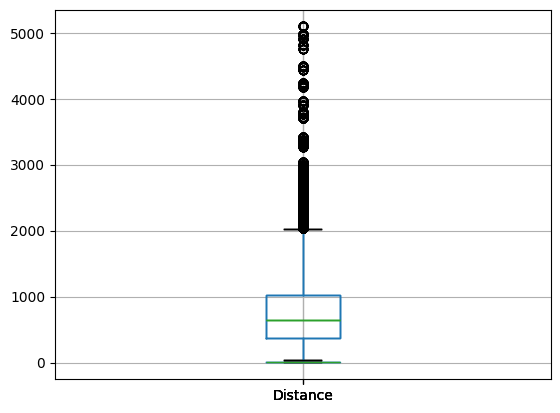

In [29]:
df[["Distance"]].boxplot();
plt.show()

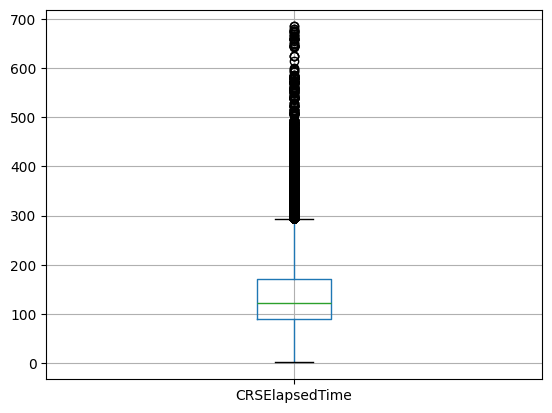

In [32]:
df[["CRSElapsedTime"]].boxplot();
plt.show()

In [3]:
num = df.loc[:, ("Distance","CRSElapsedTime")]
df["Distance"].corr(df["CRSElapsedTime"])

0.9826663217474899

Only two numerical features, however they are highly correlated, remove one in this case CRSElapsedTime.

Because there are outliers, use RobustScaler for this.

### Target encoding & balancing

In [61]:
df["BadFlight"] = ((df['DepartureDelayGroups'] > 0) | (df['Cancelled'] > 0)).astype(int)

In [34]:
delay_groups = df['DepartureDelayGroups']
delay_groups[delay_groups>0].value_counts().sort_index()/len(delay_groups[delay_groups>0])

DepartureDelayGroups
1.0     0.356316
2.0     0.189170
3.0     0.117944
4.0     0.077333
5.0     0.055125
6.0     0.041445
7.0     0.032896
8.0     0.024305
9.0     0.017954
10.0    0.014351
11.0    0.012254
12.0    0.060906
Name: count, dtype: float64

In [62]:
df[["BadFlight"]].value_counts()/len(df)

BadFlight
0            0.768467
1            0.231533
Name: count, dtype: float64

In [63]:
df["DepartureDelayGroups"]

0        -1.0
1        -1.0
2         4.0
3         NaN
4        -1.0
         ... 
239995    0.0
239996    5.0
239997    3.0
239998    0.0
239999   -1.0
Name: DepartureDelayGroups, Length: 240000, dtype: float64

In [35]:
df["DepartureDelayGroups"]=df["DepartureDelayGroups"].fillna("Cancelled")

In [75]:
times = {}
for i in range(1,13):
    times[i] = i*15
    
times

{1: 15,
 2: 30,
 3: 45,
 4: 60,
 5: 75,
 6: 90,
 7: 105,
 8: 120,
 9: 135,
 10: 150,
 11: 165,
 12: 180}

In [36]:
buckets = {
    '_0':[-1.0, -2.0, 0],
    '_1_Less30': [1.0, 2.0],
    '_2_Betw30-105': [3.0, 4.0, 5.0, 6.0, 7.0],
    '_3_Over120/Canc': [8.0, 9.0, 10.0, 11.0, 12.0, 'Cancelled']
}

def map_to_bucket(x):
    for bucket_name,bucket_values in buckets.items():
        if x in bucket_values:
            return bucket_name

# Map original classes to new buckets using the function
df['Delay_Groups_y'] = df['DepartureDelayGroups'].apply(map_to_bucket)

In [37]:
df[['Delay_Groups_y']].value_counts()/len(df)

Delay_Groups_y 
_0                 0.768679
_1_Less30          0.111654
_2_Betw30-105      0.066471
_3_Over120/Canc    0.053196
Name: count, dtype: float64

Give weight to underrepresented in LogisticRegression. Use metric like sensitivity/recall. Impute more bad flights OR remove to get 50/50

Use LabelEncoder for the above to make them numerical when predicting.

In [38]:
y1 = df[['BadFlight']]
y2 = df[['Delay_Groups_y']]
y3 = df[['DepDelayMinutes']]

## Feature selection & bins

### Smaller groups for the departure and arrival time blocks

In [119]:
def map_to_TimeBlk(x):
    grouped_TimeBlk = {
    'morning': ['0600-0659', '0700-0759', '0800-0859', '0900-0959','1000-1059', '1100-1159'],
    'daytime': ['1200-1259','1300-1359','1400-1459','1500-1559','1600-1659','1700-1759'],
    'night': ['1800-1859','1900-1959','2000-2059','2100-2159','2200-2259', '2300-2359','0001-0559']
    }
    for bucket_name,bucket_values in grouped_TimeBlk.items():
        if x in bucket_values:
            return bucket_name

# Map original classes to new buckets using the function
df['groups_DepTimeBlk'] = df['DepTimeBlk'].apply(map_to_TimeBlk)
df['groups_ArrTimeBlk'] = df['ArrTimeBlk'].apply(map_to_TimeBlk)

### Make Month and Day of Week cyclical to capture seasonality

In [110]:
df['Month_sin'] = np.sin(2 * np.pi * df['Month'] / 12)
df['Month_cos'] = np.cos(2 * np.pi * df['Month'] / 12)

df['DayOfWeek_sin'] = np.sin(2 * np.pi * df['DayOfWeek'] / 7)
df['DayOfWeek_cos'] = np.cos(2 * np.pi * df['DayOfWeek'] / 7)

### Select X Features

In [39]:
# X = df.drop(columns=['Tail_Number', 'CarrierDelay', 'WeatherDelay', 'NASDelay',
#        'SecurityDelay', 'LateAircraftDelay', 'BadFlight', 'Delay_Groups_y',
#              'Distance', 'ArrTime', 'ArrDelay', 'ArrDelayMinutes', 'ArrDel15',
#        'ArrivalDelayGroups','CRSDepTime', 'CRSArrTime' , 'Cancelled', 'CancellationCode',
#        'Diverted', 'CRSElapsedTime', 'ActualElapsedTime', 'AirTime', 'DepTime', 'DepDelay',
#        'DepDelayMinutes', 'DepDel15', 'DepartureDelayGroups', 
#         'DestCityName', 'DestState', 'OriginCityName', 'OriginState', 'DestAirportID',
#      'Flight_Number_Operating_Airline', 'OriginAirportID','FlightDate','DayofMonth',
#                     'DepTimeBlk', 'ArrTimeBlk', 'DayOfWeek', 'Month'])

In [68]:
X = df.drop(columns=['Tail_Number', 'CarrierDelay', 'WeatherDelay', 'NASDelay',
       'SecurityDelay', 'LateAircraftDelay', 'BadFlight', 'Delay_Groups_y',
             'Distance', 'ArrTime', 'ArrDelay', 'ArrDelayMinutes', 'ArrDel15',
       'ArrivalDelayGroups','CRSDepTime', 'CRSArrTime' , 'Cancelled', 'CancellationCode',
       'Diverted', 'CRSElapsedTime', 'ActualElapsedTime', 'AirTime', 'DepTime', 'DepDelay',
       'DepDelayMinutes', 'DepDel15', 'DepartureDelayGroups', 
        'DestCityName', 'DestState', 'OriginCityName', 'OriginState', 'DestAirportID',
     'Flight_Number_Operating_Airline', 'OriginAirportID','FlightDate','DayofMonth'])

In [69]:
X.columns

Index(['Month', 'DayOfWeek', 'Operating_Airline ', 'Origin', 'Dest',
       'DepTimeBlk', 'ArrTimeBlk', 'DistanceGroup'],
      dtype='object')

# Final code

## Pipeline & encoding

In [130]:
df = pd.read_csv("random_data.csv")
df = df.drop("Unnamed: 0", axis = 1)

In [282]:
df_2k = pd.read_csv("base_data_2k.csv")
df_2k = df_2k.drop("Unnamed: 0", axis = 1)

In [131]:
X = df.drop(columns=['Tail_Number', 'CarrierDelay', 'WeatherDelay', 'NASDelay',
       'SecurityDelay', 'LateAircraftDelay',
             'Distance', 'ArrTime', 'ArrDelay', 'ArrDelayMinutes', 'ArrDel15',
       'ArrivalDelayGroups','CRSDepTime', 'CRSArrTime' , 'Cancelled', 'CancellationCode',
       'Diverted', 'CRSElapsedTime', 'ActualElapsedTime', 'AirTime', 'DepTime', 'DepDelay',
       'DepDelayMinutes', 'DepDel15', 'DepartureDelayGroups', 
        'DestCityName', 'DestState', 'OriginCityName', 'OriginState', 'DestAirportID',
     'Flight_Number_Operating_Airline', 'OriginAirportID','FlightDate','DayofMonth'])

In [283]:
X_2k = df_2k.drop(columns=['Tail_Number', 'CarrierDelay', 'WeatherDelay', 'NASDelay',
       'SecurityDelay', 'LateAircraftDelay',
             'Distance', 'ArrTime', 'ArrDelay', 'ArrDelayMinutes', 'ArrDel15',
       'ArrivalDelayGroups','CRSDepTime', 'CRSArrTime' , 'Cancelled', 'CancellationCode',
       'Diverted', 'CRSElapsedTime', 'ActualElapsedTime', 'AirTime', 'DepTime', 'DepDelay',
       'DepDelayMinutes', 'DepDel15', 'DepartureDelayGroups', 
        'DestCityName', 'DestState', 'OriginCityName', 'OriginState', 'DestAirportID',
     'Flight_Number_Operating_Airline', 'OriginAirportID','FlightDate','DayofMonth'])

In [236]:
X_2k.columns

Index(['Month', 'DayOfWeek', 'Operating_Airline', 'Origin', 'Dest',
       'DepTimeBlk', 'ArrTimeBlk', 'DistanceGroup'],
      dtype='object')

In [132]:
X.columns

Index(['Month', 'DayOfWeek', 'Operating_Airline ', 'Origin', 'Dest',
       'DepTimeBlk', 'ArrTimeBlk', 'DistanceGroup'],
      dtype='object')

### Target encoding

In [64]:
df["BadFlight"] = ((df['DepartureDelayGroups'] > 0) | (df['Cancelled'] > 0)).astype(int)

In [65]:
df["DepartureDelayGroups"]=df["DepartureDelayGroups"].fillna("Cancelled")

buckets = {
    '_0':[-1.0, -2.0, 0],
    '_1_Less30': [1.0, 2.0],
    '_2_Betw30-105': [3.0, 4.0, 5.0, 6.0, 7.0],
    '_3_Over120/Canc': [8.0, 9.0, 10.0, 11.0, 12.0, 'Cancelled']
}

def map_to_bucket(x):
    for bucket_name,bucket_values in buckets.items():
        if x in bucket_values:
            return bucket_name

# Map original classes to new buckets using the function
df['Delay_Groups_y'] = df['DepartureDelayGroups'].apply(map_to_bucket)

In [66]:
y1 = df[['BadFlight']]
y2 = df[['Delay_Groups_y']]
y3 = df[['DepDelayMinutes']]

### Feature selection & encoding preproc

In [114]:
from sklearn.compose import make_column_selector
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import make_union
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.base import TransformerMixin, BaseEstimator

Put everything into FunctionTransformers (the bins etc) so inputs in API will work. Test pipeline with exporting pickle and trying in new file.

In [15]:
def map_to_TimeBlk(X):
    grouped_TimeBlk = {
        'morning': ['0600-0659', '0700-0759', '0800-0859', '0900-0959', '1000-1059', '1100-1159'],
        'daytime': ['1200-1259', '1300-1359', '1400-1459', '1500-1559', '1600-1659', '1700-1759'],
        'night': ['1800-1859', '1900-1959', '2000-2059', '2100-2159', '2200-2259', '2300-2359', '0001-0559']
    }

    # Create a new 'TimeBlock' column based on the categories
    df['groups_DepTimeBlk'] = df['DepTimeBlk'].apply(lambda x: next((key for key, values in grouped_TimeBlk.items() if x in values), None))
    df['groups_ArrTimeBlk'] = df['ArrTimeBlk'].apply(lambda x: next((key for key, values in grouped_TimeBlk.items() if x in values), None))
    
    return X[['groups_DepTimeBlk', 'groups_ArrTimeBlk']]

map_to_TimeBlk(df)

,groups_DepTimeBlk,groups_ArrTimeBlk
0,daytime,daytime
1,morning,morning
2,night,night
3,morning,morning
4,morning,daytime
...,...,...
239995,morning,daytime
239996,night,night
239997,daytime,daytime
239998,daytime,daytime


In [16]:
def cyclical_transform_month(X):
    X['Month_sin'] = np.sin(2 * np.pi * X['Month'] / 12)
    X['Month_cs'] = np.cos(2 * np.pi * df['Month'] / 12)

    X['DayOfWeek_sin'] = np.sin(2 * np.pi * X['DayOfWeek'] / 7)
    X['DayOfWeek_cos'] = np.cos(2 * np.pi * X['DayOfWeek'] / 7)
    
    return X[['Month_sin','Month_cos', 'DayOfWeek_sin','DayOfWeek_cos']]

cyclical_transform_month(df)

,Month_sin,Month_cos,DayOfWeek_sin,DayOfWeek_cos
0,5.000000e-01,0.866025,7.818315e-01,0.623490
1,5.000000e-01,0.866025,-2.449294e-16,1.000000
2,5.000000e-01,0.866025,-9.749279e-01,-0.222521
3,5.000000e-01,0.866025,-2.449294e-16,1.000000
4,5.000000e-01,0.866025,4.338837e-01,-0.900969
...,...,...,...,...
239995,-2.449294e-16,1.000000,9.749279e-01,-0.222521
239996,-2.449294e-16,1.000000,9.749279e-01,-0.222521
239997,-2.449294e-16,1.000000,9.749279e-01,-0.222521
239998,-2.449294e-16,1.000000,-2.449294e-16,1.000000


In [70]:
X.columns

Index(['Month', 'DayOfWeek', 'Operating_Airline ', 'Origin', 'Dest',
       'DepTimeBlk', 'ArrTimeBlk', 'DistanceGroup'],
      dtype='object')

In [284]:
class MyTrans(TransformerMixin, BaseEstimator):
    def __init__(self):
        pass
    
    def fit(self, X):
        self.grouped_TimeBlk = {
            'morning': ['0600-0659', '0700-0759', '0800-0859', '0900-0959', '1000-1059', '1100-1159'],
            'daytime': ['1200-1259', '1300-1359', '1400-1459', '1500-1559', '1600-1659', '1700-1759'],
            'night': ['1800-1859', '1900-1959', '2000-2059', '2100-2159', '2200-2259', '2300-2359', '0001-0559']
            }
        return self
        
    def transform(self, X):
        X['Month_sin'] = np.sin(2 * np.pi * X['Month'] / 12)
        X['Month_cos'] = np.cos(2 * np.pi * X['Month'] / 12)
        X['DayOfWeek_sin'] = np.sin(2 * np.pi * X['DayOfWeek'] / 7)
        X['DayOfWeek_cos'] = np.cos(2 * np.pi * X['DayOfWeek'] / 7)
    
        X['groups_DepTimeBlk'] = X['DepTimeBlk'].apply(lambda x: next((key for key, values in self.grouped_TimeBlk.items() if x in values), None))
        X['groups_ArrTimeBlk'] = X['ArrTimeBlk'].apply(lambda x: next((key for key, values in self.grouped_TimeBlk.items() if x in values), None))
        
        X = X.drop(columns = ['DepTimeBlk', 'ArrTimeBlk', 'Month', 'DayOfWeek'])

        return X
    


In [241]:
transformation = MyTrans()
transformation.fit(X_2k)


MyTrans()

In [244]:
new = transformation.transform(X_2k)

In [245]:
new.columns

Index(['Operating_Airline', 'Origin', 'Dest', 'DistanceGroup', 'Month_sin',
       'Month_cos', 'DayOfWeek_sin', 'DayOfWeek_cos', 'groups_DepTimeBlk',
       'groups_ArrTimeBlk'],
      dtype='object')

In [285]:
cat_col = make_column_selector(dtype_include=['object'])
ord_col = make_column_selector(dtype_include=['int64'])
cat_transformer = OneHotEncoder(sparse = False, handle_unknown="ignore")
transformer2 = MyTrans()

preproc_tranformation = make_column_transformer( 
    (cat_transformer, cat_col),
    remainder = "passthrough"
    )


preproc_basic = make_pipeline(transformer2, preproc_tranformation)

preproc_basic

Pipeline(steps=[('mytrans', MyTrans()),
                ('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x433ba8910>)]))])

In [177]:
preproc_basic.fit(X)

/Users/ronjaboehmer/.pyenv/versions/3.10.6/envs/flightdelay/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Pipeline(steps=[('mytrans', MyTrans()),
                ('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x13a4b2590>)]))])

In [286]:
preproc_basic.fit(X_2k)

/Users/ronjaboehmer/.pyenv/versions/3.10.6/envs/flightdelay/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Pipeline(steps=[('mytrans', MyTrans()),
                ('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x433ba8910>)]))])

In [262]:
selected_columns = ['DistanceGroup', 'Month_sin', 'Month_cos', 'DayOfWeek_sin', 'DayOfWeek_cos']
all_transformed_cols = transformer2.transform(X_2k).columns
selected_transformed_cols = all_transformed_cols.intersection(selected_columns)
selected_transformed_cols

Index(['DistanceGroup', 'Month_sin', 'Month_cos', 'DayOfWeek_sin',
       'DayOfWeek_cos'],
      dtype='object')

In [287]:
X_2k_transformed = pd.DataFrame(
    preproc_basic.transform(X_2k), 
    columns=np.concatenate([
    preproc_basic.named_steps['columntransformer'].named_transformers_['onehotencoder'].get_feature_names_out(),
    selected_transformed_cols ]))


In [288]:
X_2k_transformed

,Operating_Airline_9E,Operating_Airline_AA,Operating_Airline_AS,Operating_Airline_B6,Operating_Airline_C5,Operating_Airline_DL,Operating_Airline_F9,Operating_Airline_G4,Operating_Airline_G7,Operating_Airline_HA,...,groups_DepTimeBlk_morning,groups_DepTimeBlk_night,groups_ArrTimeBlk_daytime,groups_ArrTimeBlk_morning,groups_ArrTimeBlk_night,DistanceGroup,Month_sin,Month_cos,DayOfWeek_sin,DayOfWeek_cos
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,5.000000e-01,0.866025,7.818315e-01,0.623490
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,4.0,5.000000e-01,0.866025,-2.449294e-16,1.000000
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,3.0,5.000000e-01,0.866025,-9.749279e-01,-0.222521
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,2.0,5.000000e-01,0.866025,-2.449294e-16,1.000000
4,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,2.0,5.000000e-01,0.866025,4.338837e-01,-0.900969
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1999,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,1.0,-2.449294e-16,1.000000,4.338837e-01,-0.900969
2000,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,5.0,-2.449294e-16,1.000000,4.338837e-01,-0.900969
2001,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,1.0,-2.449294e-16,1.000000,9.749279e-01,-0.222521
2002,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,6.0,-2.449294e-16,1.000000,7.818315e-01,0.623490


In [115]:
len(X_transformed)

240000

In [139]:
len(X_2k_transformed)

2004

In [117]:
X_transformed.to_csv("transformed_random_data_240000.csv")

In [289]:
X_2k_transformed.to_csv("transformed_random_data_2004_cols.csv")

In [246]:
pd.DataFrame(cols).to_csv("cols.csv")

In [281]:
import pickle

# Export Pipeline as pickle file
with open("preproc_vs1.pkl", "wb") as file:
    pickle.dump(preproc_basic, file)